# ISM 6251 Project: Predicting Diabetes with Machine Learning

The National Health and Nutrition Examination Survey (NHANES), administered by the Centers for Disease Control and Prevention (CDC), collects extensive health and nutritional information from a diverse U.S. population.

Though expansive, the dataset is often too broad for specific analytical purposes. In this sub-dataset, we narrow our focus to predicting respondents' diabete status by extracting a subset of features from the larger NHANES dataset. These selected features include physiological measurements, lifestyle choices, and biochemical markers, which were hypothesized to have strong correlations with diabetes. The variables below are included in the dataset:

- **SEQN**: Respondent sequence number/ID
- **age_group**: Age group (Senior/Adult)
- **RIDAGEYR**: Age
- **RIAGENDR**: Gender (1: Male, 2: Female)
- **PAQ605**: If the respondent engages in moderate or vigorious intensity sports, fitness, or recreational activities in the typical week. (1: Yes, 2: No, 7: Refused)
- **BMXBMI**: Body Mass Index
- **LBXGLU**: Blood glucose after fasting (mg/dL)
- **DIQ010**: Respondent was diagnosed with diabetes (1: Yes, 2: No, 3: Borderline)
- **LBXGLT**: Oral glucose after 2 hours (mg/dL)
- **LBXIN**: Blood insulin levels (uU/mL)



## **1. IMPORTING THE DATA**
---

In [ ]:
# Install the ucimlrepo package
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# Fetch dataset
health_data = fetch_ucirepo(id=887)

# Data frame
df = health_data.data.original

# Metadata
print(health_data.metadata)

# Variable information
print(health_data.variables)


{'uci_id': 887, 'name': 'National Health and Nutrition Health Survey 2013-2014 (NHANES) Age Prediction Subset', 'repository_url': 'https://archive.ics.uci.edu/dataset/887/national+health+and+nutrition+health+survey+2013-2014+(nhanes)+age+prediction+subset', 'data_url': 'https://archive.ics.uci.edu/static/public/887/data.csv', 'abstract': "The National Health and Nutrition Examination Survey (NHANES), administered by the Centers for Disease Control and Prevention (CDC), collects extensive health and nutritional information from a diverse U.S. population. Though expansive, the dataset is often too broad for specific analytical purposes. In this sub-dataset, we narrow our focus to predicting respondents' age by extracting a subset of features from the larger NHANES dataset. These selected features include physiological measurements, lifestyle choices, and biochemical markers, which were hypothesized to have strong correlations with age.", 'area': 'Health and Medicine', 'tasks': ['Classifi

## **2. DATA EXPLORATION**
---



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [ ]:
df.head(10)

,SEQN,age_group,RIDAGEYR,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
0,73564.0,Adult,61.0,2.0,2.0,35.7,110.0,2.0,150.0,14.91
1,73568.0,Adult,26.0,2.0,2.0,20.3,89.0,2.0,80.0,3.85
2,73576.0,Adult,16.0,1.0,2.0,23.2,89.0,2.0,68.0,6.14
3,73577.0,Adult,32.0,1.0,2.0,28.9,104.0,2.0,84.0,16.15
4,73580.0,Adult,38.0,2.0,1.0,35.9,103.0,2.0,81.0,10.92
5,73581.0,Adult,50.0,1.0,2.0,23.6,110.0,2.0,100.0,6.08
6,73587.0,Adult,14.0,1.0,2.0,38.7,94.0,2.0,202.0,21.11
7,73596.0,Adult,57.0,2.0,2.0,38.3,107.0,2.0,164.0,20.93
8,73607.0,Senior,75.0,1.0,2.0,38.9,89.0,2.0,113.0,17.47
9,73610.0,Adult,43.0,1.0,1.0,28.9,90.0,2.0,95.0,3.24


**1. Data preprocessing**

In [ ]:
# Rename the columns for readability
df.rename(columns={
    'SEQN': 'ID',
    'age_group': 'AGE_GROUP',
    'RIDAGEYR': 'AGE',
    'RIAGENDR': 'GENDER',
    'PAQ605': 'PHYSICAL_ACT',
    'BMXBMI': 'BMI',
    'LBXGLU': 'GLUCOSE',
    'DIQ010': 'DIABETIC',
    'LBXGLT': 'ORAL',
    'LBXIN': 'INSULIN'
    }, inplace=True)

In [ ]:
# There is only 1 respondent that answered 7 (Refused) for PHYSICAL_ACT
df.drop(df[df['PHYSICAL_ACT'] == 7].index, inplace=True)

In [ ]:
# We will transform categorical variables in the dataset

# AGE_GROUP becomes SENIOR with 1 = Senior and 0 = Adult (or non-Senior)
# This is based on the fact that diabetes is more common among seniors.
df['SENIOR'] = df['AGE_GROUP'].map({'Senior': 1, 'Adult': 0}).astype('category')
df.drop(columns=['AGE_GROUP'], inplace=True)

In [ ]:
# GENDER
df['GENDER'] = df['GENDER'].astype('category')

# PHYSICAL_ACT
df['PHYSICAL_ACT'] = df['PHYSICAL_ACT'].map({1: 1, 2: 0}).astype('category')

# DIABETIC
# 0 = Yes, 1 = Borderline, 2 = No. This mapping represents the order of the variable better
df['DIABETIC'] = df['DIABETIC'].map({1: 0, 2: 2, 3: 1}).astype('category')

In [ ]:
# Rearrange the columns
column_order = ['ID'] + ['SENIOR'] + [col for col in df.columns if col not in ['ID', 'SENIOR', 'DIABETIC']] + ['DIABETIC']
df = df[column_order]

**2. Summary**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2277 entries, 0 to 2277
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   ID            2277 non-null   float64 
 1   SENIOR        2277 non-null   category
 2   AGE           2277 non-null   float64 
 3   GENDER        2277 non-null   category
 4   PHYSICAL_ACT  2277 non-null   category
 5   BMI           2277 non-null   float64 
 6   GLUCOSE       2277 non-null   float64 
 7   ORAL          2277 non-null   float64 
 8   INSULIN       2277 non-null   float64 
 9   DIABETIC      2277 non-null   category
dtypes: category(4), float64(6)
memory usage: 133.9 KB


There is no missing value in the dataset.

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,2277.0,78693.261309,2921.234210,73564.00,76174.00,78750.00,81214.00,83727.00
AGE,2277.0,41.791831,20.159615,12.00,24.00,41.00,58.00,80.00
BMI,2277.0,27.958191,7.249129,14.50,22.80,26.80,31.20,70.10
GLUCOSE,2277.0,99.548529,17.892423,63.00,91.00,97.00,104.00,405.00
ORAL,2277.0,115.000439,47.060374,40.00,87.00,105.00,130.00,604.00
INSULIN,2277.0,11.838129,9.719642,0.14,5.86,9.04,14.44,102.29


**3. Diabetic status distribution**

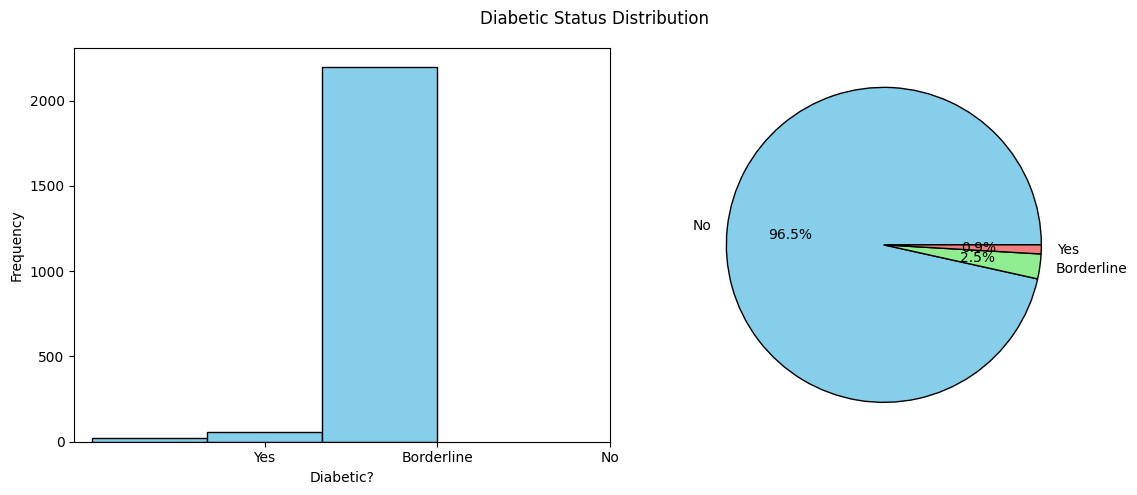

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (12, 5))

# Historgram
axs[0].hist(df['DIABETIC'], bins = 3, color = 'skyblue', edgecolor = 'black')
axs[0].set_xticks([1, 2, 3], ['Yes', 'Borderline', 'No'])
axs[0].set_xlabel('Diabetic?')
axs[0].set_ylabel('Frequency')

# Pie chart
diabetic_counts = df['DIABETIC'].value_counts()
axs[1].pie(diabetic_counts, labels = ['No', 'Borderline', 'Yes'],
           autopct = '%1.1f%%', colors = ['skyblue', 'lightgreen', 'lightcoral'],
           wedgeprops = {'edgecolor': 'black'})


fig.suptitle('Diabetic Status Distribution')
plt.tight_layout()
plt.show()

The majority of the respondents do not have diabetes. The dataset is extremely imbalanced.

This will be important as we develop our machine learning models, specifically with setting up the class_weight='balanced' for some models and calculating the f1 score using macro average.

## **3. MODEL BUILDING**

---



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, recall_score, roc_auc_score

In [ ]:
# Run the code if you have question about these ML models
# XGBClassifier?
# SVC?
# OneVsRestClassifier?

**1. Train test split**

In [ ]:
"""
NOTE:
- The training set is used to train the model, when you .fit(X_train, y_train)
- The validatiion set is used to evaluate the model performance, calculating f1, recall, and ROC AUC,
  and for hyperparameter turning.
- The test set is used to assess the final model performance. Basically, we will not use this
  until after the final model is selected and tuned.
"""

'\nIMPORTANT NOTE:\n- The training set is used to train the model, when you .fit(X_train, y_train)\n- The validatiion set is used to evaluate the model performance, calculating f1, recall, and ROC AUC,\n  and for hyperparameter turning.\n- The test set is used to assess the final model performance. Basically, we will not use this\n  until after the final model is selected and tuned.\n'

In [ ]:
# Identify target (Y) and predictor (X) variables
X = df.drop(columns=['ID', 'DIABETIC'])
y = df['DIABETIC']

# Train test split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=20)


In [ ]:
# Display the sets after splitting
data_model = {
    'Training': (X_train, y_train),
    'Validation': (X_val, y_val),
    'Testing': (X_test, y_test)
}

for name, (X_data, y_data) in data_model.items():
    df = X_data.copy()
    df['DIABETIC'] = y_data.values
    print(f'\n{name} data set:')
    print(df)
    print('-'*80)


Training data set:
     SENIOR   AGE GENDER PHYSICAL_ACT   BMI  GLUCOSE   ORAL  INSULIN DIABETIC
159       0  26.0    1.0            0  21.3     95.0   81.0     2.71        2
777       1  69.0    2.0            0  30.7     96.0   91.0     7.87        2
2267      0  33.0    2.0            0  30.0    101.0  149.0    15.82        2
827       0  38.0    2.0            1  26.0     91.0   51.0     3.60        2
2072      0  41.0    1.0            0  36.8    106.0  131.0     8.22        2
...     ...   ...    ...          ...   ...      ...    ...      ...      ...
791       0  41.0    2.0            0  21.9     94.0   71.0     5.45        2
2113      0  55.0    1.0            1  21.8     89.0   90.0     2.83        2
120       0  20.0    2.0            0  21.9     82.0   82.0     2.54        2
1636      0  44.0    1.0            0  23.9     94.0  114.0     7.63        2
1397      0  45.0    1.0            1  23.4     99.0  101.0     4.52        2

[1365 rows x 9 columns]
-------------------

**2. Normalization**

In [ ]:
# Scaling
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

# X_val and X_test are scaled using X_train scaling parameters to avoid leakage
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


**3. Models**


The following machine learning models are selected for our project:
- K Nearest Neighbors
- Ensembles: Random Forest & XGBoost
- Logistic Regression: because our target is multiclass, we use OneVsRestClassifier to handle the data.
- Support Vector Machine
- Naive Bayes

To evaluate their performance, we will focus on Recall, F1 score, and ROC AUC. Recall is our primary metric, as we would like to minimize false negative in predicting diabetes, which would cause serious issues to actual positive patients.

In [ ]:
# Initialize list to store model performance results
results = []

# Define models
models = {
    'KNN': KNeighborsClassifier(),
    'RandomForest': RandomForestClassifier(class_weight='balanced'),
    'LogisticRegression': OneVsRestClassifier(LogisticRegression(class_weight='balanced')),
    'XGBoost': XGBClassifier(class_weight='balanced'),
    'SVM': SVC(class_weight='balanced', probability=True),
    'Naive Bayes': MultinomialNB()
}

# Train, evaluate, and collect metrics for each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # Calculate performance metrics
    metrics = {
        'Model': model_name,
        'F1 Score': f1_score(y_val, y_pred, average='macro'),
        'Recall': recall_score(y_val, y_pred, average='macro'),
        'ROC AUC': roc_auc_score(y_val, model.predict_proba(X_val), multi_class='ovr', average='macro')
    }
    results.append(metrics)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:25:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


**4. Performance evaluation**


In [ ]:
results_df = pd.DataFrame(results)
results_df

,Model,F1 Score,Recall,ROC AUC
0,KNN,0.327381,0.333333,0.516968
1,RandomForest,0.327381,0.333333,0.756561
2,LogisticRegression,0.319124,0.403788,0.791185
3,XGBoost,0.327381,0.333333,0.740797
4,SVM,0.295175,0.334091,0.771593
5,Naive Bayes,0.327381,0.333333,0.563924


Based on the results, Logistic Regression returns the best performance with the highest Recall and ROC AUC. Therefore, we will continue tuning this model to improve its performance.

However, overall, the scores across the board are not exactly impressive. This is because we choose average='macro' to adress the imbalance in our data. The models would return much better performance if average='weighted' was selected. We believe was not sampled appropriately, and it could have yielded better results if it was recollected in a different way.

## **4. HYPERPARAMETER TUNING**

In [ ]:
from sklearn.model_selection import StratifiedKFold

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)

# Parameters for LogisticRegression Grid Search
param_grid = {
    'estimator__C': [0.1, 1, 10],
    'estimator__penalty': ['l1'],
    'estimator__solver': ['liblinear', 'saga'],
    'estimator__max_iter': [100, 200, 500, 1000, 2000]
}

# Initialize LogisticRegression and GridSearchCV
logreg = OneVsRestClassifier(LogisticRegression(class_weight='balanced'))
grid_search = GridSearchCV(logreg, param_grid, cv=stratified_kfold, scoring='f1_macro')

# Train the model
grid_search.fit(X_train, y_train)

# Get best model and its parameters
best_logreg = grid_search.best_estimator_

# Make predictions
y_pred = best_logreg.predict(X_val)
y_pred_proba = best_logreg.predict_proba(X_val)

# Calculate performance metrics
metrics = {
    'Model': 'Logistic Regression',
    'F1 Score': f1_score(y_val, y_pred, average='macro'),
    'Recall': recall_score(y_val, y_pred, average='macro'),
    'ROC AUC': roc_auc_score(y_val, y_pred_proba, multi_class='ovr', average='macro')
}

metrics_df = pd.DataFrame([metrics])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which 

Best Parameters: {'estimator__C': 1, 'estimator__max_iter': 200, 'estimator__penalty': 'l1', 'estimator__solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
print("Best parameters:", grid_search.best_params_)
print("Peformance after tuning:")
metrics_df

Best parameters: {'estimator__C': 1, 'estimator__max_iter': 200, 'estimator__penalty': 'l1', 'estimator__solver': 'saga'}
Peformance after tuning:


,Model,F1 Score,Recall,ROC AUC
0,Logistic Regression,0.343123,0.530303,0.827561


F1, Recall, and ROC AUC improve significantly after tuning. We will continue testing our tuned model with unseen data (X_test and y_test).

## **5. LOGISTIC REGRESSION PERFORMANCE ON TEST DATA**

In [ ]:
# Make final predictions
y_final_pred = best_logreg.predict(X_test)
y_final_pred_proba = best_logreg.predict_proba(X_test)

# Calculate performance metrics
metrics_final = {
    'Model': 'Logistic Regression',
    'F1 Score': f1_score(y_test, y_final_pred, average='macro'),
    'Recall': recall_score(y_test, y_final_pred, average='macro'),
    #'ROC AUC': roc_auc_score(y_test, y_final_pred_proba, multi_class='ovr', average='macro')
}

metrics_final_df = pd.DataFrame([metrics_final])
metrics_final_df

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,F1 Score,Recall
0,Logistic Regression,0.308202,0.442708
